## Regulatory Compliance Analysis

This notebook analyzes Thessaloniki's short-term rental licensing compliance 
patterns to identify regulatory framework effectiveness and concentration risks. H and how many do Airbnb continue to advertise and profit from?

### Regulatory Background
- **Regular Licenses:** Standard operating permits (required for most properties)
- **Exempt Status:** Policy exemptions for specific property categories
- **Duplicate Licenses:** Single license shared across multiple properties
- **NA/Missing:** Properties operating without clear licensing status

### Question
How many listings are unlicensed or falsely claiming exemptions? Is the licensing system achieving its policy objectives of equitable market access while preventing operator concentration?

In [152]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path.cwd().parent / "data" / "processed"
df = pd.read_parquet(data_path / "listings_cleaned.parquet")
pd.set_option('display.float_format', '{:,.2f}'.format)
df.shape

(4817, 47)

In [153]:
# Set global style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")  # or "husl", "muted", "pastel", "deep", "colorblind"

# For matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("Set2"))

In [154]:
na_mask = df["license"].isna()
dupli_mask = df["license"].duplicated(keep=False) & df["license"].notna() & (df["license"] != "exempt")
exempt_mask = df["license"] == "exempt"

na_df = df[na_mask]
dupli_df = df[dupli_mask]
exempt_df = df[exempt_mask]

In [ ]:
print("=" * 50)
print("LICENSE STATUS OVERVIEW")
print("=" * 50)
print(f"Licensed listings:   {(1 - na_mask.mean()):.2%}")
print(f"Duplicate licenses:  {dupli_mask.mean():.2%}")
print(f"Exempt licenses:     {exempt_mask.mean():.2%}")
print(f"Unlicensed (NA):     {na_mask.mean():.2%}")

LICENSE STATUS OVERVIEW
Licensed listings:   99.4%
Duplicate licenses:  7.7%
Exempt licenses:     0.9%
Unlicensed (NA):     0.6%


### NA licenses

In [156]:
print(f"Unlicensed listings: {len(na_df):,}")

Unlicensed listings: 27


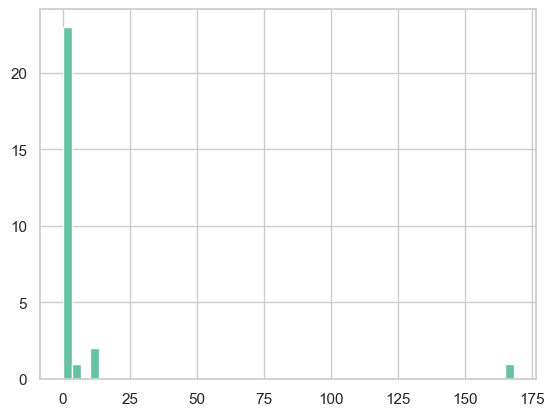

In [157]:
na_df.estimated_occupancy_l365d.hist(bins=50);

In [158]:
active_unlicensed = na_df.loc[na_df["estimated_occupancy_l365d"] != 0].shape[0]
recent_reviews = na_df.loc[na_df["last_review"] > "2023-01-01"].shape[0]

print(f"With non-zero occupancy: {active_unlicensed}")
print(f"With reviews after 2023: {recent_reviews}")

With non-zero occupancy: 4
With reviews after 2023: 4


In [159]:
interesting_host_id = na_df.loc[na_df["estimated_revenue_l365d"].idxmax()]["host_id"]
df.loc[df["host_id"] == interesting_host_id][["host_total_listings_count", "price",
                                              "number_of_reviews_ltm", "estimated_revenue_l365d"]].describe()

,host_total_listings_count,price,number_of_reviews_ltm,estimated_revenue_l365d
count,0.00,26.00,28.00,26.00
mean,<NA>,68.69,10.86,"4,148.77"
std,<NA>,26.97,6.78,"2,939.84"
min,<NA>,38.00,0.00,0.00
25%,<NA>,50.00,6.00,"1,971.00"
50%,<NA>,62.00,11.00,"3,555.00"
75%,<NA>,75.00,14.25,"6,145.50"
max,<NA>,133.00,28.00,"12,096.00"


In [160]:
# Categorize the interesting host's listings
df.loc[df["host_id"] == interesting_host_id, "Host_Category"] = 'Large Multi (4+)'

In [161]:
na_df["last_review"].sort_values(ascending=False).head(10)

532    2025-06-23
753    2025-06-10
769    2025-06-09
579    2025-06-04
969    2020-03-02
301    2020-03-01
107    2020-02-28
283    2020-02-08
413    2019-09-12
694    2019-07-15
Name: last_review, dtype: object

* Apart from 4 listings that seem currently active, all the rest seem like deactivated listings
* An interesting finding is one host that has 28 active listings but is not categorized as a multi host due to missing data

### Exempt Licenses

In [162]:
print(f"Exempt listings: {len(exempt_df):,}")

Exempt listings: 41


<Axes: ylabel='property_type'>

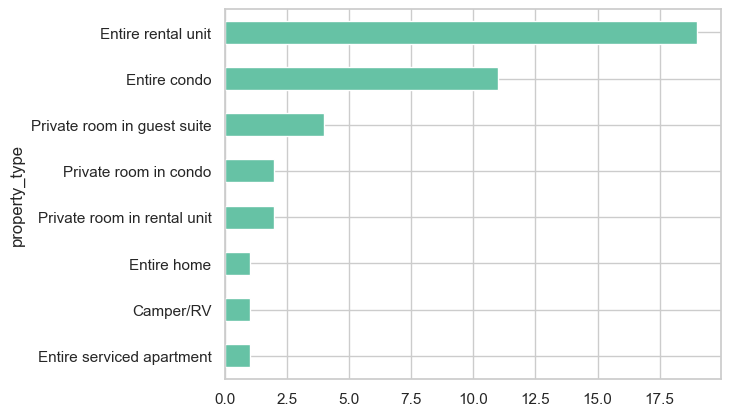

In [ ]:
exempt_df["property_type"].value_counts(ascending=True).tail(8).plot.barh();

In [164]:
exempt_df.loc[:, "last_review"] = pd.to_datetime(exempt_df["last_review"])

exempt_df.groupby(['host_id', "host_location"]).agg(
    listing_count=("host_id", "count"),
    total_revenue_l365d=("estimated_revenue_l365d", "sum"),
    min_availability_365d=("availability_365", "min"),
    last_review_date=("last_review", "max")
).sort_values("listing_count", ascending=False).reset_index()

,host_id,host_location,listing_count,total_revenue_l365d,min_availability_365d,last_review_date
0,HOST_5CBB76,"Belgrade, Serbia",12,822.00,348,2024-11-25 00:00:00
1,HOST_195D33,"London, United Kingdom",5,"8,304.00",180,2025-06-08 00:00:00
2,HOST_5A66C8,"Thessaloniki, Greece",3,0.00,170,2024-05-20 00:00:00
3,HOST_415740,"Thessaloniki, Greece",2,282.00,264,2025-06-07 00:00:00
4,HOST_C42CEA,"Thessaloniki, Greece",2,"1,500.00",330,2025-06-04 00:00:00
5,HOST_42A087,"Thessaloniki, Greece",1,0.00,69,NaT
6,HOST_44DB4F,"Thessaloniki, Greece",1,0.00,266,NaT
7,HOST_4A9714,"Thessaloniki, Greece",1,0.00,351,NaT
8,HOST_4AE6F3,"Łódź, Poland",1,0.00,363,NaT
9,HOST_4AED84,"Thessaloniki, Greece",1,0.00,365,NaT


In [165]:
top_2_per = exempt_df["host_id"].value_counts(normalize=True).head(2).sum()
print(f"Top 2 hosts account for {top_2_per:.2%} of all exemptions.")

Top 2 hosts account for 41.46% of all exemptions.


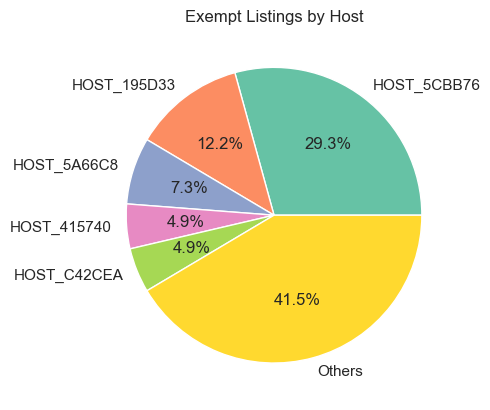

In [166]:
counts = exempt_df["host_id"].value_counts()
top_n = counts.head(5)
others = pd.Series({'Others': counts.iloc[5:].sum()})
pd.concat([top_n, others]).plot(kind='pie', autopct='%1.1f%%', title='Exempt Listings by Host')
plt.ylabel('');

In [167]:
superhosts = exempt_df.loc[exempt_df["host_is_superhost"] == True].shape[0]
print(f"Superhosts among exempt: {superhosts}")

Superhosts among exempt: 4


* A few hosts with multiple exemptions, especially one host with almost 30% of all exemptions (41.5% between the top 2)
* No particular geographical pattern that warrants exemptions
* Apart from one listing that is of type "Camper/RV", all the rest are regular of property type
* Minimum availability for most listings is quite high, indicating properties that are not main residences
* Many hosts are not located in Greece
* Many listings have recent reviews, indicating active rentals
* 4 of these hosts are superhosts

<hr>

### Duplicate Licenses

In [168]:
print(f"Listings with duplicate licenses: {len(dupli_df):,}")

Listings with duplicate licenses: 370


**Note:** The `location` column is derived by rounding latitude and longitude coordinates to 3 decimal places (approximately 111-meter precision) and concatenating them. While this provides a reasonable proxy for identifying distinct listing locations, results should be interpreted with caution due to potential rounding artifacts and data quality variations.

In [169]:
dupli_df.loc[:, "location"] = round(dupli_df["latitude"], 3).astype(str) + "_" + round(dupli_df["longitude"], 3).astype(str)

dupli_groupped = dupli_df.groupby("license").agg(
    host_count=("host_id", "nunique"),
    location_count=("location", "nunique"),
    listings_count=("license", "count"),
    total_revenue=("estimated_revenue_l365d", "sum"),
    avg_reviews_ltm=("number_of_reviews_ltm", "mean"),
).sort_values(["host_count", "location_count"], ascending=False)

dupli_groupped.head(20)

/var/folders/ks/037drkhd42324wgwpk_m9_940000gn/T/ipykernel_6077/3589861132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dupli_df.loc[:, "location"] = round(dupli_df["latitude"], 3).astype(str) + "_" + round(dupli_df["longitude"], 3).astype(str)


,host_count,location_count,listings_count,total_revenue,avg_reviews_ltm
license,,,,,
LIC_7C3F33BD,3,8,19,"6,682.00",1.32
LIC_5783A8BB,2,4,5,"3,168.00",0.40
LIC_7BF7E0E7,2,4,4,"10,836.00",8.00
LIC_92500C3A,2,4,5,"22,476.00",19.80
LIC_F0538B36,2,4,4,"1,200.00",1.00
LIC_C57F46E7,2,3,3,612.00,12.33
LIC_0010A65B,2,2,2,"11,802.00",7.50
LIC_061E18A2,2,2,2,"8,700.00",17.50
LIC_19B84233,2,2,2,0.00,0.00


In [170]:
# Flag suspicious licenses: multiple hosts OR multiple locations
dupli_licenses_to_drop = dupli_groupped.loc[
    (dupli_groupped["location_count"] > 2) | (dupli_groupped["host_count"] > 1)
].index
dupli_indices_to_drop = dupli_df.loc[dupli_df["license"].isin(dupli_licenses_to_drop)].index

print(f"Suspicious licenses flagged: {len(dupli_licenses_to_drop)}")
print(f"Listings to exclude: {len(dupli_indices_to_drop):,}")

Suspicious licenses flagged: 27
Listings to exclude: 127


In [171]:
pct_flagged = len(dupli_indices_to_drop) / len(dupli_df)
print(f"Share of duplicate licenses flagged: {pct_flagged:.1%}")

Share of duplicate licenses flagged: 34.3%


In [172]:
dupli_df["host_id"].value_counts().head(5)

host_id
HOST_4497DA    54
HOST_044261    25
HOST_6D3C82    18
HOST_7C4743    11
HOST_24B31F    11
Name: count, dtype: int64

In [173]:
# Analyze top host with duplicate licenses
interesting_host_id_2 = dupli_df["host_id"].value_counts().head(1).index[0]
host_listings = dupli_df.loc[dupli_df["host_id"] == interesting_host_id_2]

print(f"Top host's unique licenses: {host_listings['license'].nunique()}")
print(f"Top host's share of duplicates: {len(host_listings) / len(dupli_df):.1%}")

Top host's unique licenses: 7
Top host's share of duplicates: 14.6%


* 13 licenses are under more than one host, 11 of them at more than one location
* 127 such listings (34% of duplicate licenses) will be dropped from further analysis
* A particular host holds 29 different listings under one license, and 54 listings (14.59% of total duplicate listings) under 7 licenses overall

<hr>

### **Summary and Recommendations**

* Apart from 4 unlicensed listings that seem currently active, all the rest seem like deactivated listings. Auditing efforts should focus on these active unlicensed listings to ensure compliance.
* Exempt licenses are predominantly held by a few hosts, with one host accounting for nearly 30% of all exemptions. This concentration suggests a need for stricter scrutiny of exemption claims to prevent potential misuse.
* Auditing efforts should also focus on listings that share their license accross multiple hosts and locations to ensure that license sharing rules are not being abused.

**Note:** The above recommendations are based on the analyzed dataset and should be validated with additional data sources and regulatory guidelines to ensure comprehensive compliance assessment.


Taking into account the previous findings, we can now separate the listings into regular and non-regular license holders, and base our further analysis on the regular ones.

In [174]:
# Combine all non-regular indices
non_regular_indices = na_df.index.union(dupli_indices_to_drop).union(exempt_df.index)
non_regular_df = df.loc[non_regular_indices]
regular_df = df.drop(index=non_regular_indices)

# Save datasets
non_regular_df.to_parquet(data_path / "listings_non_regular_license.parquet", engine="pyarrow", index=False)
regular_df.to_parquet(data_path / "listings_regular_license.parquet", engine="pyarrow", index=False)

# Final summary
print("=" * 50)
print(f"Non-regular listings: {len(non_regular_df):,} ({len(non_regular_df)/len(df):.1%})")
print(f"Regular listings:     {len(regular_df):,} ({len(regular_df)/len(df):.1%})")
print(f"\n✅ Datasets saved to {data_path.name}/")

Non-regular listings: 195 (4.0%)
Regular listings:     4,622 (96.0%)

✅ Datasets saved to processed/
